# Chapter 4: StanとRStanを始めよう

*CmdStanとCmdStanPyを使用しています

## 4.4 単回帰
### 4.4.2 データの分布の確認

shape: (5, 2)
┌─────┬─────┐
│ X   ┆ Y   │
│ --- ┆ --- │
│ i64 ┆ i64 │
╞═════╪═════╡
│ 24  ┆ 472 │
│ 24  ┆ 403 │
│ 26  ┆ 454 │
│ 32  ┆ 575 │
│ 33  ┆ 546 │
└─────┴─────┘
shape: (9, 3)
┌────────────┬───────────┬────────────┐
│ describe   ┆ X         ┆ Y          │
│ ---        ┆ ---       ┆ ---        │
│ str        ┆ f64       ┆ f64        │
╞════════════╪═══════════╪════════════╡
│ count      ┆ 20.0      ┆ 20.0       │
│ null_count ┆ 0.0       ┆ 0.0        │
│ mean       ┆ 43.35     ┆ 829.85     │
│ std        ┆ 11.952868 ┆ 272.902966 │
│ min        ┆ 24.0      ┆ 403.0      │
│ max        ┆ 59.0      ┆ 1314.0     │
│ median     ┆ 43.0      ┆ 803.0      │
│ 25%        ┆ 35.0      ┆ 601.0      │
│ 75%        ┆ 56.0      ┆ 1092.0     │
└────────────┴───────────┴────────────┘


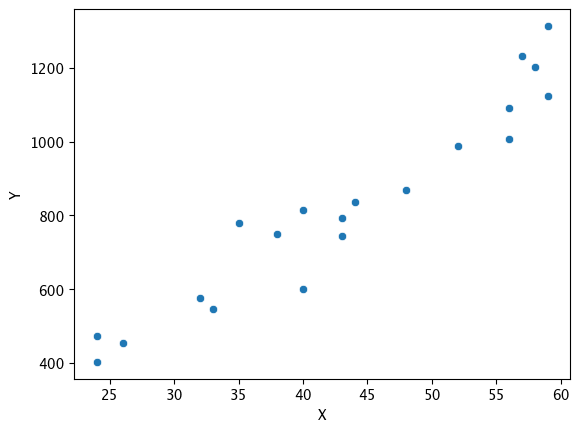

In [40]:
"""."""
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

# ファイルの読み込み
salary_lf = pl.scan_csv(Path("chap04/input/data-salary.txt"))
salary_df = salary_lf.collect()

# データの先頭5行の確認
print(salary_df.head())

# データのサマリを確認
print(salary_df.describe())

# データの図示
sns.scatterplot(data=salary_df, x="X", y="Y")
plt.show()

### 4.4.4 単回帰で推定(Rのlmで推定)

/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


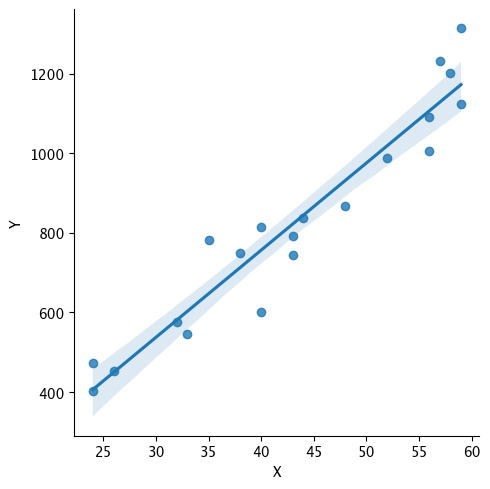

切片a: [-119.69713212]
傾きb: [[21.90420143]]
決定係数: 0.9204126558540815


In [41]:
from sklearn.linear_model import LinearRegression

# 単回帰 Seaborn
sns.lmplot(data=salary_df.to_pandas(), x="X", y="Y")
plt.show()

# 単回帰 sklearn
x = salary_df[["X"]].to_numpy()
y = salary_df[["Y"]].to_numpy()
model_lr = LinearRegression()
model_lr.fit(x, y)

print(f"切片a: {model_lr.intercept_}")
print(f"傾きb: {model_lr.coef_}")
print(f"決定係数: {model_lr.score(x, y)}")

### 4.4.5 Stanで実装

stanモデルは下記参照

[chap04/model/model4-5.stan](chap04/model/model4-5.stan)

モデル式 4-5に相当する
$$
Y[n] \sim Normal(a+bX[n], \sigma) \quad n= 1, ..., N
$$


### 4.4.6 Pythonからの実行方法(Rからの実行方法)
#### run-model4-5

In [42]:
from pathlib import Path

import polars as pl
from cmdstanpy import CmdStanModel

# stanファイルのパス
STAN_MODEL_PATH = Path("chap04/model/model4-5.stan")
# データのパス
DATA_PATH = Path("chap04/input/data-salary.txt")


# ファイルの読み込み
salary_lf = pl.scan_csv(DATA_PATH)
salary_df = salary_lf.collect()

stan_data = {
    "N": salary_df.shape[0],
    "X": salary_df["X"].to_list(),
    "Y": salary_df["Y"].to_list(),
}

sm = CmdStanModel(stan_file=STAN_MODEL_PATH)
# デフォルトのパラメーターはnum_samples=1000, num_warmup=1000, num_thin=1
fit = sm.sample(data=stan_data, seed=1234)

15:39:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                       

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


15:39:39 - cmdstanpy - INFO - CmdStan done processing.


### 4.4.7 CmdStanPyの結果の見方

In [43]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-93.7212,0.038239,1.36340,-96.3633,-93.3801,-92.22610,1271.27,9630.83,1.00132
a,-119.5740,2.389660,77.04620,-249.6450,-119.1760,3.62683,1039.52,7875.13,1.00168
b,21.8884,0.054224,1.72278,19.1418,21.8988,24.79060,1009.45,7647.32,1.00257
sigma,85.7544,0.407763,16.05710,64.1121,83.3953,114.97600,1550.66,11747.40,1.00265


- mean: 事後平均。例えばb(係数)は約21.9なので、年齢が1上がるごとに基本年収が約29万円上がると解釈
- MCSE: モンテカルロ標準誤差
- N_eff: 自己相関などから判断した実行的なMCMCサンプル数.テキストによると100程度以上が望ましい。
- R_hat($\hat{R}$): MCMCが収束したかを表す指標の一つ


### 4.4.8 収束診断をファイルへ出力する

array([[<Axes: title={'center': 'lp__'}>,
        <Axes: title={'center': 'lp__'}>]], dtype=object)

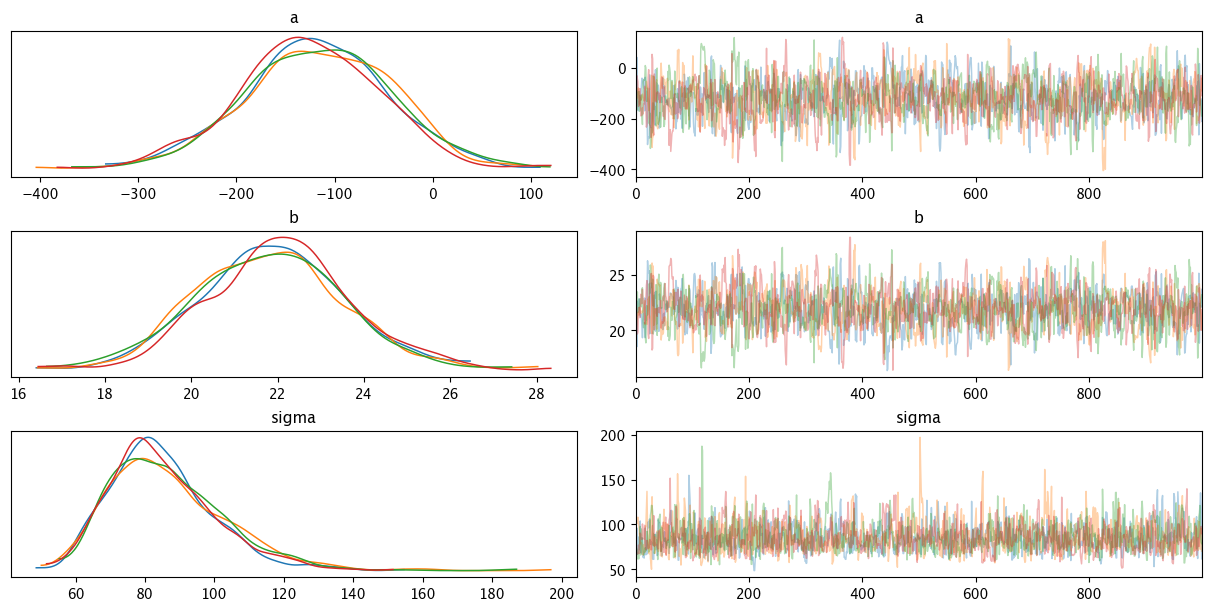

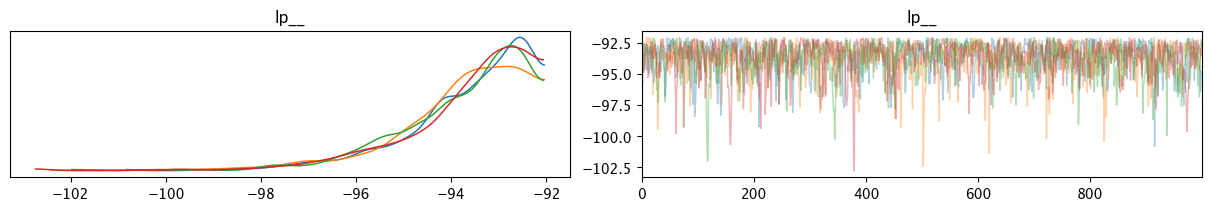

In [44]:
import arviz as az

cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)

ll_data = cmdstanpy_data.log_likelihood
az.plot_trace(
    cmdstanpy_data,
    var_names=["a", "b", "sigma"],
    compact=False,
    backend_kwargs={"constrained_layout": True},
)
az.plot_trace(ll_data, compact=False, backend_kwargs={"constrained_layout": True})

### 4.4.9 MCMCの設定の変更
#### rstan-modify-MCMCsettings.Rのpython版

15:39:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


15:39:41 - cmdstanpy - INFO - CmdStan done processing.


array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

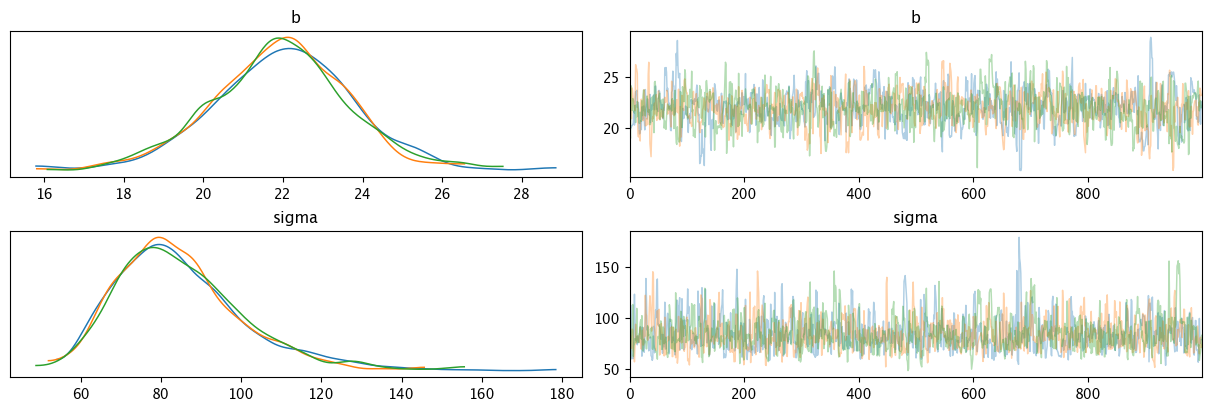

In [45]:
import numpy as np

rg = np.random.default_rng(1)

# cmdstanではサンプリング時にparsを指定できない
# CmdStanMCMC.draws(), CmdStanMCMC.draws_pd(), InferenceData変換後などに対処する必要がある.
fit = sm.sample(
    data=stan_data,
    inits={"a": rg.integers(-10, 10), "b": rg.integers(0, 10), "sigma": 10},
    seed=123,
    chains=3,
    iter_sampling=1000,
    iter_warmup=200,
    thin=1,
)

cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)


az.plot_trace(
    cmdstanpy_data,
    var_names=["b", "sigma"],
    compact=False,
    backend_kwargs={"constrained_layout": True},
)

- 解析の再現性のためにも、乱数のseedは常に指定する癖をつけること
- chains, iter_sampling, iter_warmup, thinの決め方
    - chains: 最低3はほしい(Stan開発チームは4を推奨)
    - iter_sampling: モデルを試行錯誤しているうちは500~1000ぐらいで実行。最終モデルが決まったら大きくしていく。テキストでは最終的に1k~5kにしている。一般にMCMCを用いた推論では、後平均を1桁正確に推定するのに、中心極限定理より、100倍のMCMCサンプルが必要となる。
    - iter_warmup: traceplotを見て決める。モデルに依存してかなり変わるが100~500で十分なケースが多い。
    - thin: 通常は1にしている。サンプル列の自己相関が低く、１のままで十分であることがStanの利点。しかし、trace plotが図4.6の左のように特定のパラメータで急激に変動する場合はthinの値を5などに増やすことで対処する。(一時的な影響を減らして、自己相関を減らす)。右図のような場合は自己相関が高すぎるため、モデルそのものの改善が必要
![Alt text](chap04/output/fig4-6.png)

### 4.4.10 並列計算の実行方法

In [46]:
from pathlib import Path

import polars as pl
from cmdstanpy import CmdStanModel

# stanファイルのパス
STAN_MODEL_PATH = Path("chap04/model/model4-5.stan")
# データのパス
DATA_PATH = Path("chap04/input/data-salary.txt")


# ファイルの読み込み
salary_lf = pl.scan_csv(DATA_PATH)
salary_df = salary_lf.collect()

stan_data = {
    "N": salary_df.shape[0],
    "X": salary_df["X"].to_list(),
    "Y": salary_df["Y"].to_list(),
}

# cpp_options={"STAN_THREADS": "TRUE"} で並列計算がONになる
sm = CmdStanModel(
    stan_file=STAN_MODEL_PATH,
    compile="force",
    cpp_options={"STAN_THREADS": "TRUE"},
)
# デフォルトのパラメーターはnum_samples=1000, num_warmup=1000, num_thin=1
fit = sm.sample(data=stan_data, seed=1234)

15:39:42 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5
15:39:46 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5
15:39:46 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
15:39:46 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5.hpp /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5.stan
Warning in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    t


15:39:46 - cmdstanpy - INFO - CmdStan done processing.


### 4.4.11 ベイズ信頼区間とベイズ予測区間の算出
#### rstan-extract-MCMCsamples.Rのpython版

In [60]:
from pathlib import Path

import polars as pl
from cmdstanpy import CmdStanModel

# stanファイルのパス
STAN_MODEL_PATH = Path("chap04/model/model4-5.stan")
# データのパス
DATA_PATH = Path("chap04/input/data-salary.txt")

# ファイルの読み込み
salary_lf = pl.scan_csv(DATA_PATH)
salary_df = salary_lf.collect()

stan_data = {
    "N": salary_df.shape[0],
    "X": salary_df["X"].to_list(),
    "Y": salary_df["Y"].to_list(),
}

# cpp_options={"STAN_THREADS": "TRUE"} で並列計算がONになる
sm = CmdStanModel(
    stan_file=STAN_MODEL_PATH,
    compile="force",
    cpp_options={"STAN_THREADS": "TRUE"},
)
# デフォルトのパラメーターはnum_samples=1000, num_warmup=1000, num_thin=1
fit = sm.sample(data=stan_data, seed=1234)

11:33:09 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5
11:33:13 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5
11:33:13 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
11:33:13 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5.hpp /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5.stan
Warning in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap04/model/model4-5.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    t


11:33:13 - cmdstanpy - INFO - CmdStan done processing.


In [61]:
print(fit.b)  # fit.stan_variable(var="b")と同じ
# 95%ベイズ信頼区間.
np.quantile(fit.b, q=[0.025, 0.975])

[25.3397 24.2714 18.5243 ... 22.0173 20.0008 21.853 ]


array([18.57862 , 25.446065])

          a        b    sigma
0 -252.3380  25.3397  96.9995
1 -238.6050  24.2714  70.5480
2   42.4698  18.5243  96.0643
3  -93.1197  21.5389  66.6718
4 -145.2240  22.6140  68.1158
5 -168.5760  22.4478  85.9058
                 a            b
count  4000.000000  4000.000000
mean   -119.574176    21.888436
std      77.046230     1.722779
min    -404.673000    16.394300
25%    -168.583000    20.738825
50%    -119.183500    21.897950
75%     -67.585625    22.995200
max     120.995000    28.341000


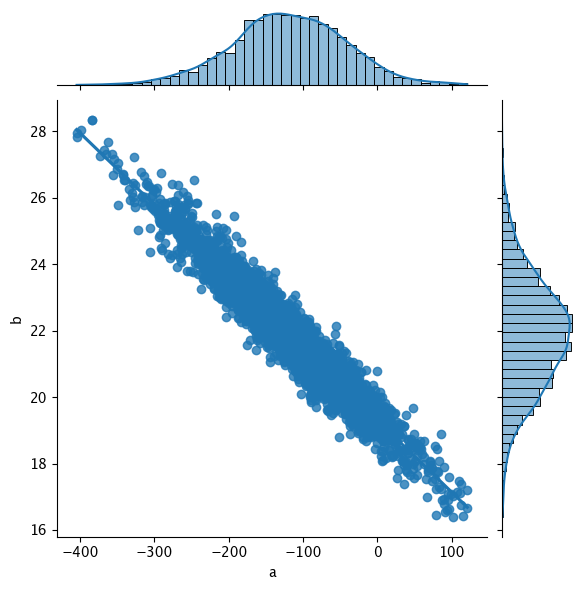

In [64]:
# a, b, σの同時分布で有ることを確認
import seaborn as sns

print(fit.draws_pd(vars=["a", "b", "sigma"]).head(6))
d_mcmc_df = fit.draws_pd(vars=["a", "b"])
print(d_mcmc_df.describe())

sns.jointplot(d_mcmc_df, x="a", y="b", kind="reg")

In [50]:
# 50歳の人の基本年収の分布(からのMCMCサンプル)と年収の予測分布(からのMCMCサンプル)を作成
N_mcmc = fit.draws_pd(vars=["lp__"]).size
y50_base = fit.a + fit.b * 50
rg = np.random.default_rng(1)
y50 = rg.normal(y50_base, fit.sigma, N_mcmc)
d_mcmc = pl.DataFrame(
    {"a": fit.a, "b": fit.b, "sigma": fit.sigma, "y50_base": y50_base, "y50": y50},
)
d_mcmc

a,b,sigma,y50_base,y50
f64,f64,f64,f64,f64
-252.338,25.3397,96.9995,1014.647,1048.168494
-238.605,24.2714,70.548,974.965,1032.928517
42.4698,18.5243,96.0643,968.6848,1000.428006
-93.1197,21.5389,66.6718,983.8253,896.941462
-145.224,22.614,68.1158,985.476,1047.145039
-168.576,22.4478,85.9058,953.814,992.160165
-131.283,22.8313,82.743,1010.282,965.852878
-139.833,21.911,71.7014,955.717,997.383982
-106.278,21.2905,103.871,958.247,996.115499


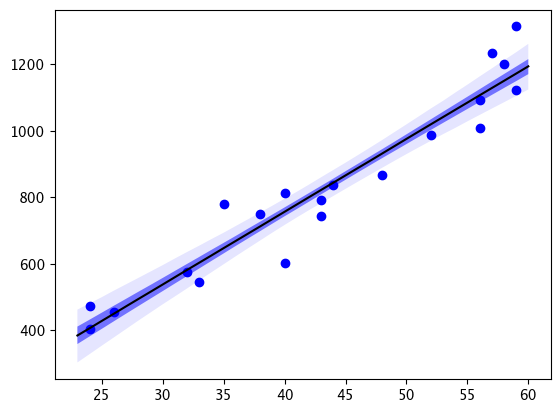

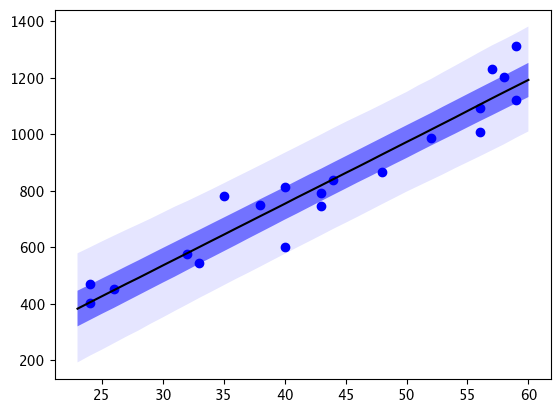

In [51]:
# 23~60歳の各年齢について実施
import numpy as np
from matplotlib import pyplot as plt
from numpy import ndarray

N_mcmc = fit.draws_pd(vars=["lp__"]).size
QUANTILE_LIST = [0.025, 0.25, 0.5, 0.75, 0.975]


def CalcQuantiles(age) -> tuple[ndarray, ndarray]:
    """MCMCサンプリングを行い、分位数を計算.

    Args:
        age (_type_): _description_

    Returns:
        tuple[ndarray, ndarray]: _description_
    """
    yXX_base = fit.a + fit.b * age
    rg = np.random.default_rng(1)
    yXX = rg.normal(yXX_base, fit.sigma, N_mcmc)
    return np.quantile(yXX_base, q=QUANTILE_LIST).T, np.quantile(yXX, q=QUANTILE_LIST).T


AGE_RANGE = list(range(23, 60 + 1))
base_salary_q_np = np.ndarray(shape=(0, len(QUANTILE_LIST)))
salary_q_np = np.ndarray(shape=(0, len(QUANTILE_LIST)))
for i in AGE_RANGE:
    base_salary_q, salary_q = CalcQuantiles(i)
    base_salary_q_np = np.vstack([base_salary_q_np, base_salary_q])
    salary_q_np = np.vstack([salary_q_np, salary_q])

# 23~60歳の各年齢における基本年収のベイズ信頼区間
base_q_0_025 = base_salary_q_np[:, 0].tolist()
base_q_0_25 = base_salary_q_np[:, 1].tolist()
base_q_0_5 = base_salary_q_np[:, 2].tolist()
base_q_0_75 = base_salary_q_np[:, 3].tolist()
base_q_0_975 = base_salary_q_np[:, 4].tolist()

plt.fill_between(AGE_RANGE, base_q_0_025, base_q_0_975, facecolor="blue", alpha=0.1)
plt.fill_between(AGE_RANGE, base_q_0_25, base_q_0_75, facecolor="blue", alpha=0.5)
plt.plot(AGE_RANGE, base_q_0_5, "k-")
plt.scatter(salary_df["X"], salary_df["Y"], c="b")
plt.show()

# 23~60歳の各年齢における年収のベイズ信頼区間
q_0_025 = salary_q_np[:, 0].tolist()
q_0_25 = salary_q_np[:, 1].tolist()
q_0_5 = salary_q_np[:, 2].tolist()
q_0_75 = salary_q_np[:, 3].tolist()
q_0_975 = salary_q_np[:, 4].tolist()

plt.fill_between(AGE_RANGE, q_0_025, q_0_975, facecolor="blue", alpha=0.1)
plt.fill_between(AGE_RANGE, q_0_25, q_0_75, facecolor="blue", alpha=0.5)
plt.plot(AGE_RANGE, q_0_5, "k-")
plt.scatter(salary_df["X"], salary_df["Y"], c="b")
plt.show()

### 4.4.12 transformed parametersブロックとgenerated quantitiesブロック

前項のstanコードでは呼び出し側の(R, Pythonの)コードが複雑になりやすく、
- バグが入りやすい
- 計算速度が遅い
- 作業全体の見通しが悪い

などデメリットが多いため、できるだけstan側で処理を行うように修正する。

そのためにはtransformed parametersブロックとgenerated quantitiesブロックを利用する。transformed parametersブロックは特に、データやパラメータを組み合わせて"="の関係でパラメータ変数を作る場合も使うので重要。

#### model4-4.stan
[chap04/model/model4-4.stan](chap04/model/model4-4.stan)


```stan
data {
  int N;
  real X[N];
  real Y[N];
+  int N_new;
+  real X_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

// transformed parameterブロック
// parametersブロックで定義された変数を使用できる。関数を使って計算した新たにサンプリングする変数を作ることができる。以降のブロックで新たに定義された変数を利用できる
+ transformed parameters {
+   real y_base[N];
+   for (n in 1:N)
+     y_base[n] = a + b*X[n];  // for文の中身が1行のみの場合は{}を省略できる
+ }
```

モデル式 4-4に相当する
$$
\begin{align}
&y_{base}[n] = a+bX[n] &n= 1, ..., N \nonumber \\
&Y[n] \sim Normal(y_{base}[n], \sigma) &n= 1, ..., N \nonumber
\end{align}
$$


```stan

model {
+   for (n in 1:N)
    Y[n] ~ normal(y_base[n], sigma);
}

// generated quantitiesブロック
// 新しい年齢データX_newに対する基本年収y_base_newと、ノイズの項も考慮した年収y_newを定義している
// このブロックではdataブロック、parameterブロク、transformed parametersブロックで宣言されたパラメータ及び定数値から、四則演算とlogなどの関数を使って新たにサンプリングする変数を作ることができる。このブロックは事後確率と完全に切り離されていて計算が早い。
// このブロック内では"~"は使用できないため、ある分布に従う乱数を発生させたい場合は"~ 分布名()"の代わりに"分布名_rng()"という関数を用い、"="で代入する。
+ generated quantities {
+   real y_base_new[N_new];
+   real y_new[N_new];
+   for (n in 1:N_new) {
+     y_base_new[n] = a + b*X_new[n];
+     y_new[n] = normal_rng(y_base_new[n], sigma);
+   }
+ }

```


#### run-model4-4.Rのpython版

/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:01:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


16:01:00 - cmdstanpy - INFO - CmdStan done processing.


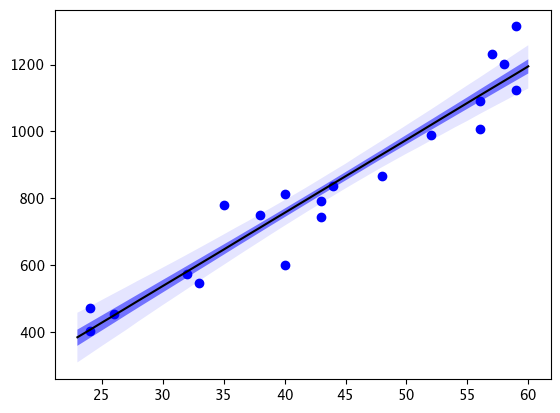

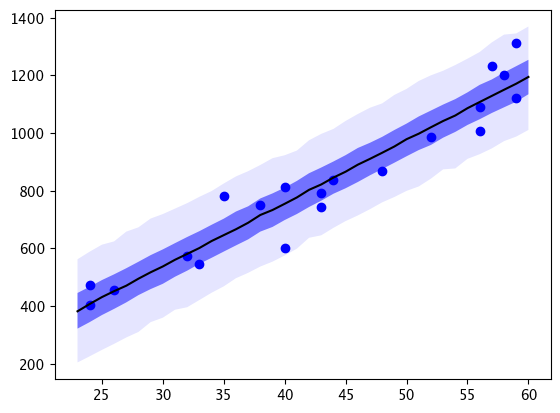

In [1]:
from pathlib import Path

import polars as pl
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt
from pandas import DataFrame

# stanファイルのパス
STAN_MODEL_PATH = Path("chap04/model/model4-4.stan")
# データのパス
DATA_PATH = Path("chap04/input/data-salary.txt")
# 年齢の範囲23~60
X_NEW = list(range(23, 61))
# 分位点
Q_LIST = (0.025, 0.25, 0.5, 0.75, 0.975)


# 分位点を計算して追加
def dataframe_quantile_mcmc(x: list[int], y_mcmc: DataFrame, probs=Q_LIST) -> DataFrame:
    """."""
    qua = y_mcmc.quantile(q=probs)
    d = qua.T
    # 行列名を修正
    d = d.set_axis(x, axis=0)
    d = d.set_axis([f"p{p*100}" for p in probs], axis=1)
    return d


# プロット
def plot_5quantile(data: DataFrame, d_est: DataFrame, X_NEW: list[int]) -> None:
    """."""
    p2_5 = d_est.loc[:, "p2.5"].tolist()
    p25 = d_est.loc[:, "p25.0"].tolist()
    p50 = d_est.loc[:, "p50.0"].tolist()
    p75 = d_est.loc[:, "p75.0"].tolist()
    p97_5 = d_est.loc[:, "p97.5"].tolist()

    plt.fill_between(X_NEW, p2_5, p97_5, facecolor="blue", alpha=0.1)
    plt.fill_between(X_NEW, p25, p75, facecolor="blue", alpha=0.5)
    plt.plot(X_NEW, p50, "k-")
    plt.scatter(data["X"], data["Y"], c="b")
    plt.show()


# データの読み込み
salary_lf = pl.scan_csv(DATA_PATH)
salary_df = salary_lf.collect()

stan_data = {
    "N": salary_df.shape[0],
    "X": salary_df["X"].to_list(),
    "Y": salary_df["Y"].to_list(),
    "N_new": len(X_NEW),
    "X_new": X_NEW,
}

sm = CmdStanModel(stan_file=STAN_MODEL_PATH, cpp_options={"STAN_THREADS": "TRUE"})
fit = sm.sample(data=stan_data, seed=1234)

d_est = dataframe_quantile_mcmc(X_NEW, fit.draws_pd(vars="y_base_new"))
plot_5quantile(salary_df, d_est, X_NEW)

d_est = dataframe_quantile_mcmc(X_NEW, fit.draws_pd(vars="y_new"))
plot_5quantile(salary_df, d_est, X_NEW)

In [53]:
# y_newの確認(23~26歳分)
fit.draws_pd(vars=["y_new"]).iloc[:, 0:4]

,y_new[1],y_new[2],y_new[3],y_new[4]
0,284.217,391.516,240.488,446.853
1,335.874,335.250,564.071,376.333
2,409.078,338.406,349.220,461.749
3,374.685,238.247,537.329,480.452
4,371.009,472.932,440.891,458.998
...,...,...,...,...
3995,372.613,406.358,442.400,523.008
3996,364.196,370.024,516.507,471.129
3997,276.039,431.758,564.852,503.019
3998,386.743,451.879,531.667,455.650


## 練習問題

t検定に相当することをstanで行う。

以下のPythonコードで生成されたデータを用いて、グループ1(Y1)の平均${\mu}_1$と、グループ2(Y2)の平均${\mu}_2$に差があるか、$Prob[{\mu}_1 < {\mu}_2] ({\mu}_1 < {\mu}_2である確率)$を求めることで判断したい

In [54]:
import numpy as np

rg = np.random.default_rng(123)
N1 = 30
N2 = 20
Y1 = rg.normal(loc=0, scale=5, size=N1)
Y2 = rg.normal(loc=1, scale=4, size=N2)

(1) 各グループの値に差が認められるか、おおよそ把握するために図を描け。

<Axes: xlabel='group', ylabel='Y'>

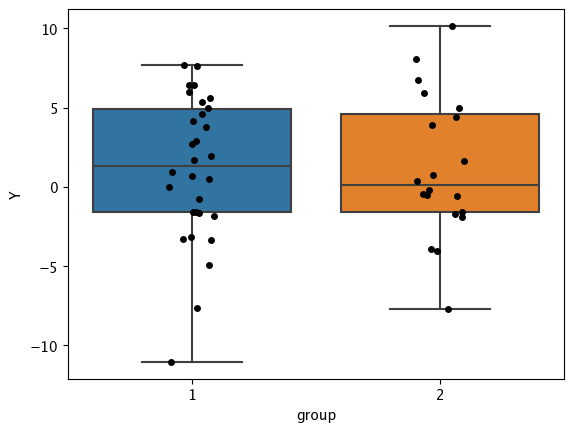

In [55]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt

Y1_df = pl.DataFrame(Y1, "Y")
Y1_df = Y1_df.with_columns(pl.lit(1).alias("group"), pl.col("Y"))
Y2_df = pl.DataFrame(Y2, "Y")
Y2_df = Y2_df.with_columns(pl.lit(2).alias("group"), pl.col("Y"))
Y_df = Y1_df.vstack(Y2_df)

# ボックスプロットに実値を重ねたグラフを表示
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x="group", y="Y", data=Y_df.to_pandas(), showfliers=False, ax=ax)
sns.stripplot(
    x="group",
    y="Y",
    data=Y_df.to_pandas(),
    jitter=True,
    color="black",
    ax=ax,
)

(2)  各グループで標準偏差が等しいと仮定してモデル式を書け。これはStudentoのt検定に相当する。
$$
\begin{align}
&Y_1[n] \sim Normal(\mu_1, \sigma) &n= 1, ..., N_1 \nonumber \\
&Y_2[n] \sim Normal(\mu_2, \sigma) &n= 1, ..., N_2 \nonumber
\end{align}
$$

(3) Stanで(2)のモデルファイルを作成して実行せよ。次の(4)においてPython側でMCMCサンプルの操作を練習するので、generated quantitiesブロックは使用しない。

stanモデル
[chap04/exercise/ex3.stan](chap04/exercise/ex3.stan)

```stan
data {
    int N1;
    int N2;
    real Y1[N1];
    real Y2[N2];
}

parameters {
    real mu1;
    real mu2;
    real<lower=0> sigma;
}

model {
    for (n in 1:N1)
        Y1[n] ~ Normal(mu1, sigma);
    for (n in 1:N2)
        Y2[n] ~ Normal(mu2, sigma);
}
```


In [56]:
from pathlib import Path

from cmdstanpy import CmdStanModel

STAN_MODEL_PATH = Path("chap04/exercise/ex3.stan")

stan_data = {
    "N1": N1,
    "N2": N2,
    "Y1": Y1,
    "Y2": Y2,
}

sm = CmdStanModel(stan_file=STAN_MODEL_PATH, cpp_options={"STAN_THREADS": "TRUE"})
fit = sm.sample(data=stan_data, seed=1234)

15:39:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


15:39:53 - cmdstanpy - INFO - CmdStan done processing.



(4) 得られたMCMCサンプルからPython側で$Prob[\mu_1 < \mu_2]$を計算せよ(ヒント: MCMCサンプルの中で$\mu_1 < \mu_2$となる回数をカウントして、全MCMCサンプル数で割る)。

In [57]:
prob = np.mean(fit.mu1 < fit.mu2)
prob

0.5305

In [58]:
# 別解
N_mcmc = fit.mu1.size
prob = np.sum(fit.mu1 < fit.mu2) / N_mcmc
prob

0.5305

(5) グループ毎の標準偏差が異なる場合をモデル式で表現せよ。これはWhelchのt検定に相当する。同様に$Prob[\mu_1 < \mu_2]$を計算せよ。

モデル式
$$
\begin{align}
&Y_1[n] \sim Normal(\mu_1, \sigma_1) &n= 1, ..., N_1 \nonumber \\
&Y_2[n] \sim Normal(\mu_2, \sigma_2) &n= 1, ..., N_2 \nonumber
\end{align}
$$

stanモデル

[chap04/exercise/ex5.stan](chap04/exercise/ex5.stan)

```stan
data {
  int N1;
  int N2;
  real Y1[N1];
  real Y2[N2];
}

parameters {
  real mu1;
  real mu2;
  real<lower=0> sigma1;
  real<lower=0> sigma2;
}

model {
  for (n in 1:N1)
    Y1[n] ~ normal(mu1, sigma1);
  for (n in 1:N2)
    Y2[n] ~ normal(mu2, sigma2);
}

```

In [59]:
from pathlib import Path

from cmdstanpy import CmdStanModel

STAN_MODEL_PATH = Path("chap04/exercise/ex5.stan")

stan_data = {
    "N1": N1,
    "N2": N2,
    "Y1": Y1,
    "Y2": Y2,
}

sm = CmdStanModel(stan_file=STAN_MODEL_PATH, cpp_options={"STAN_THREADS": "TRUE"})
fit = sm.sample(data=stan_data, seed=1234)

prob = np.mean(fit.mu1 < fit.mu2)
prob

15:39:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


15:39:53 - cmdstanpy - INFO - CmdStan done processing.


0.51775